# Livrable 1 - groupe 1

Nous sommes le groupe 1 composé de :  
- DELORME Alexandre
- ENCOGNERE Yanis
- MENNERON Laurine
- PEREON Alexandre
- ROCHARD Léo

## Contenu du livrable
TODO...


# TODO

##  Analyse des Résultats et Biais/VarianceAnalyse

Discussion sur le surapprentissage/sous-apprentissage

Calcul et affichage d'une matrice de confusion

Calcul de métriques supplémentaires (précision, rappel, F1-score)

## À implémenter/discuter:

Régularisation L2 dans les couches denses/convolutionnelles

Ajustement du taux de dropout

Utilisation de Batch Normalization

Transfer learning avec un modèle pré-entraîné (VGG16, ResNet, etc.)

Grid search pour optimiser les hyperparamètres

## Documentation et Justifications

Schéma de l'architecture du réseau (peut être généré avec tf.keras.utils.plot_model)

Justification des choix (architecture, hyperparamètres, etc.)

Analyse des résultats obtenus

Discussion sur les difficultés rencontrées (images réalistes dans les peintures)

## Gestion des Données Déséquilibrées

Analyse du déséquilibre entre classes photo/non-photo

Techniques pour gérer le déséquilibre (poids de classe, oversampling, etc.)

## EDA
TODO...
- Chargement du dataset
- Visualisation
- Répartition des données

### Chargement des bibliothèques

In [1]:
%load_ext tensorboard
import imghdr
import os
import pathlib
import zipfile
from collections import Counter
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Chargement du dataset


Cette partie permet de récuperer le dataset depuis le drive afin d'automatiser la pipeline. L'objectif est d'utiliser un dataset commun au sein du groupe. 

Ce dernier à le dossier "Sketch" complété par des données trouvés dans les sources suivantes : [croquis](https://paperswithcode.com/dataset/sketch) || [visages réalistes](https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs/data)

Ce qui fait passer le dossier sketch de 606 visages et 800 croquis avec un ration de 43%/57% entre visages/croquis à 1200 visages et 3200 croquis pour un ratio final équivalent.

In [15]:
# ID du fichier (extrait de l'URL)
file_id = "1d0k3mXd93JM0fLLYrUZRr4Un1F_TnuHi"
dataset_path = "dataset_livrable_1"
zip_path = dataset_path + ".zip"
extract_dir = pathlib.Path(zip_path).parent / dataset_path
reduce_dataset = True

if not os.path.exists(extract_dir):
    print(f"Le dossier '{extract_dir}' n'existe pas. Téléchargement en cours...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

    print(f"Extraction ZIP en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction Zip terminée")
else:
    print(f"Le dossier '{extract_dir}' existe déjà. Téléchargement et extraction non nécessaires.")

data_dir = extract_dir
print(f"Dataset disponible dans : {data_dir}")

Le dossier 'dataset_livrable_1' existe déjà. Téléchargement et extraction non nécessaires.
Dataset disponible dans : dataset_livrable_1


### Détection des catégories

In [16]:
categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Catégories détectées : {categories}")

Catégories détectées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


### Pré traitement des images

In [ ]:
# Function to detect and remove corrupted files
num_skipped = 0
for folder_name in categories:
    folder_path = data_dir / folder_name
    for fname in os.listdir(folder_path):
        fpath = folder_path / fname
        try:
            # Check if the file is a valid image
            if imghdr.what(fpath) is None:
                raise IOError(f"File is not a valid image: {fpath}")

            # Try to open the image file
            with tf.io.gfile.GFile(fpath, 'rb') as f:
                img_content = f.read()
            try:
                img = tf.io.decode_image(img_content, dtype=tf.dtypes.uint8, channels=3)
            except tf.errors.InvalidArgumentError as e:
                print(f"Invalid image detected and removed: {fpath}")
                num_skipped += 1
                os.remove(fpath)
                continue
        except (IOError, SyntaxError) as e:
            print(f"Corrupted file detected and removed: {fpath}")
            num_skipped += 1
            os.remove(fpath)

print(f"Number of corrupted files removed: {num_skipped}")

### Chargement des images

In [17]:
validation_split = 0.2
seed = 42
batch_size = 32
img_height = 180
img_width = 180

train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

class_names = train_set.class_names
num_classes = len(class_names)

print(f"Classes found: {class_names}")

Found 44386 files belonging to 5 classes.
Using 35509 files for training.
Found 44386 files belonging to 5 classes.
Using 8877 files for validation.
Classes found: ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


### Visualisation des différentes classes

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Répartition des classes au sein du dataset

Répartition des labels dans le jeu d'entraînement :
{'Photo': 7957, 'Schematics': 7937, 'Painting': 7994, 'Text': 8045, 'Sketch': 3576}


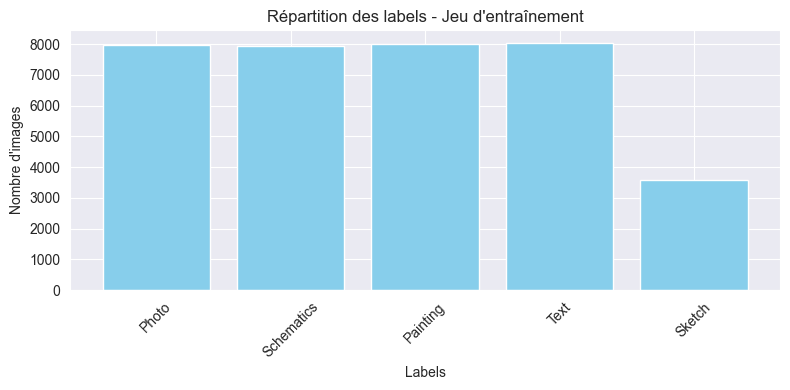

In [18]:
def count_labels(dataset):
    label_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            label_counts[class_name] = label_counts.get(class_name, 0) + 1
    return label_counts


# Compter les labels dans les jeux d'entraînement et de validation
train_label_counts = count_labels(train_set)
val_label_counts = count_labels(val_set)

# Extraire les données pour la visualisation
labels, train_counts = zip(*train_label_counts.items())

# Afficher les résultats
print("Répartition des labels dans le jeu d'entraînement :")
print(train_label_counts)

# Affichage de la répartition
plt.figure(figsize=(8, 4))
plt.bar(labels, train_counts, color="skyblue")
plt.xticks(rotation=45)
plt.title('Répartition des labels - Jeu d\'entraînement')
plt.xlabel('Labels')
plt.ylabel('Nombre d\'images')
plt.tight_layout()
plt.show()

## Modélisation

### Optimisation pour l'entrainement

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Cette commande n'est pas nécessaire sur colab
train_set = train_set.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.prefetch(buffer_size=AUTOTUNE)

### Définition de la fonction de perte

In [9]:
# Calcul des poids pour chaque classe
def compute_class_weights(dataset, class_names):
    label_counts = Counter(class_names[label] for _, labels in dataset for label in labels)
    total_samples = sum(label_counts.values())
    class_weights = {class_name: total_samples / count for class_name, count in label_counts.items()}
    return class_weights


# Calcul des poids pour l'ensemble d'entraînement
class_weights = compute_class_weights(train_set, class_names)

# Normaliser les poids pour éviter des valeurs trop grandes
max_weight = max(class_weights.values())
class_weights = {class_name: weight / max_weight for class_name, weight in class_weights.items()}

print("Class Weights:", class_weights)

# Appliquer les poids dans la fonction de perte
class_weight_tensor = tf.constant([class_weights[class_name] for class_name in class_names], dtype=tf.float32)


def weighted_loss(y_true, y_pred):
    weights = tf.gather(class_weight_tensor, tf.cast(y_true, tf.int32))
    unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return unweighted_loss * weights

Class Weights: {'Photo': 0.4494156088978258, 'Text': 0.44449968924798017, 'Schematics': 0.45054806601990677, 'Painting': 0.4473355016262197, 'Sketch': 1.0}


### Définition du modèle

In [10]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'), ]
)

model.compile(optimizer='adam', loss=weighted_loss, metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

model.summary()

C:\Users\Léo\Documents\Projets\Datascientist\WS 1\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 89, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,821 (6.35 MB)

 Trainable params: 1,664,821 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

### Entrainement

#### Définition des callbacks

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./L1_model.keras', save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#### Fit

Epoch 1/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 221s 171ms/step - accuracy: 0.4608 - loss: 5.6469 - val_accuracy: 0.7765 - val_loss: 0.2522
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 209s 162ms/step - accuracy: 0.7753 - loss: 0.2401 - val_accuracy: 0.7411 - val_loss: 0.2857
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 227s 180ms/step - accuracy: 0.8132 - loss: 0.2038 - val_accuracy: 0.8394 - val_loss: 0.1897
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 228s 174ms/step - accuracy: 0.8387 - loss: 0.1769 - val_accuracy: 0.8377 - val_loss: 0.1819
Epoch 5/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 233s 184ms/step - accuracy: 0.8502 - loss: 0.1657 - val_accuracy: 0.8407 - val_loss: 0.1787
Epoch 6/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 276s 212ms/step - accuracy: 0.8563 - loss: 0.1597 - val_accuracy: 0.8612 - val_loss: 0.1704
Epoch 7/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 231s 174ms/step - accuracy: 0.8686 - loss: 0.1525 - val_accuracy: 0.8575 - val_loss: 0.1676
Epoch 8/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 216s 166ms/step - ac

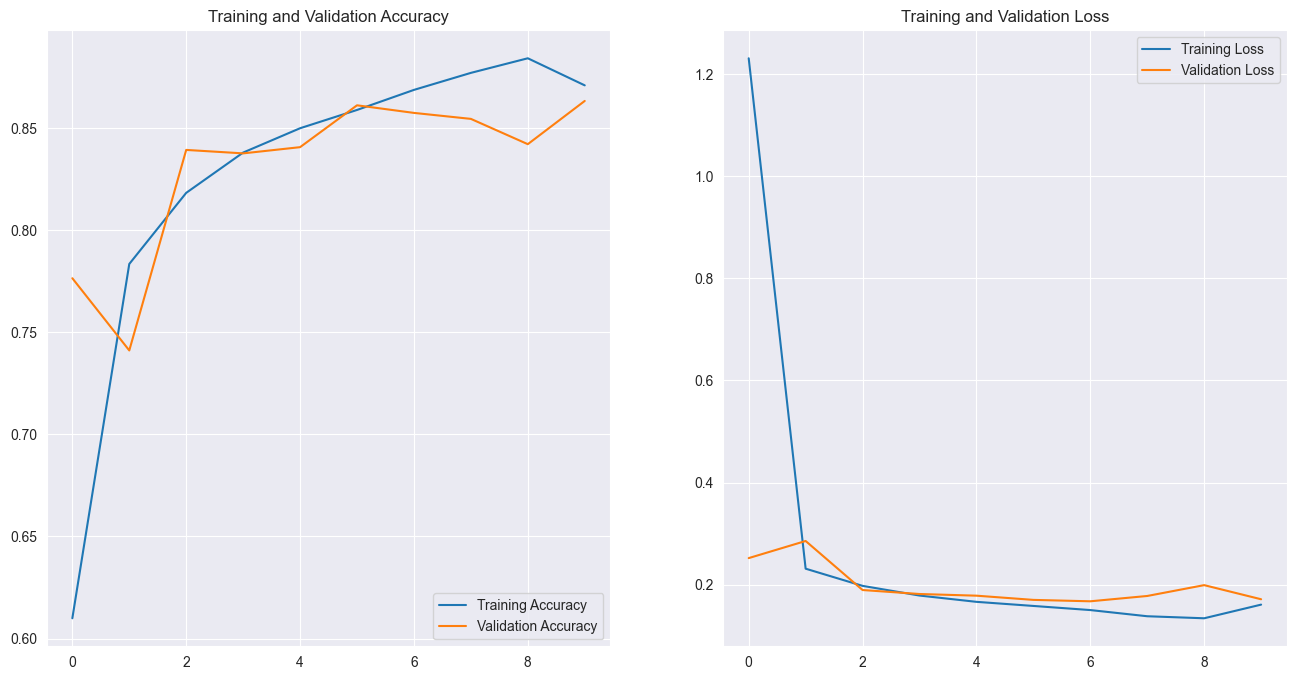

In [12]:
epochs = 10

history = model.fit(train_set,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_set,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
%tensorboard --logdir logs/fit

### Matrice de confusion et rapport de classification

In [13]:
def confusion_matrix_and_report(model, val_set):
    val_predictions = model.predict(val_set)
    val_pred_labels = np.argmax(val_predictions, axis=1)

    val_true_labels = np.concatenate([y for x, y in val_set], axis=0)

    conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matrice de Confusion")
    plt.xlabel("Classe Prédite")
    plt.ylabel("Classe Réelle")
    plt.show()
    report = classification_report(val_true_labels, val_pred_labels, target_names=class_names)

    print("Rapport de Classification :")
    print(report)

278/278 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step


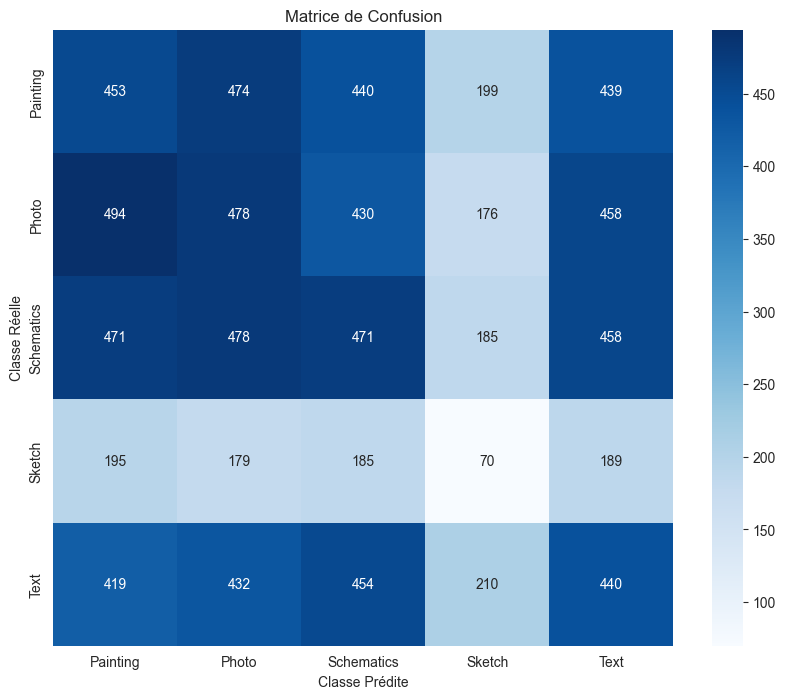

Rapport de Classification :
              precision    recall  f1-score   support

    Painting       0.22      0.23      0.22      2005
       Photo       0.23      0.23      0.23      2036
  Schematics       0.24      0.23      0.23      2063
      Sketch       0.08      0.09      0.08       818
        Text       0.22      0.23      0.22      1955

    accuracy                           0.22      8877
   macro avg       0.20      0.20      0.20      8877
weighted avg       0.22      0.22      0.22      8877



In [14]:
confusion_matrix_and_report(model, val_set)